# Lid Driven Cavity
A two-dimensional siumlation of a lid-driven cavity.  


In [1]:
%matplotlib inline

import math
import numpy as np
import matplotlib.pyplot as plt
import time


### Simulation control parameters

In [2]:
N = 151; # number of lattice points in each direction
Num_ts = 50000;
Vis_ts = 25000; # number of timesteps between visualizations
omega = 1.8; # relaxation parameter

### Geometry parameters
For a 2D square cavity, there's not much to say about the geometry

In [3]:
Lx = 1.0; Ly = Lx; # restrict ourselves, for the time being, to square cavities.

### Fluid Physical Properties and Flow Condition
To model an isothermal viscous fluid I will need to know the density and viscosity.  I also need to say *something* about the flow condition.  I could, for example, specify the lid velocity but a more generic and fundamentally relevant way to go about this is to specify the Reynolds Number for the flow.  

In [4]:
# physical density and viscosity of the fluid
rho_p = 965.3; 
nu_p = 0.06/rho_p; 

Re = 100.; # Reynolds number.

### Non-Dimensionalization
In order to model the physical fluid using the Lattice Boltzmann Method (LBM) we need to non-dimensionalize the fluid physical properties.  Doing so will allow the LBM to accurately capture the dynamics of momentum transfer throughout the domain.

In [5]:
Lo = Ly; # characteristic length
Vo = Re*nu_p/Lo; # characteric velocity for given Renolds Number
To = Lo/Vo; # characteristic time 

# convert to dimensionles units
Td = 1.0;
Ld = 1.0; # for unit spacing and transport of data between lattice sites
Ud = (To/Lo)*Vo; # non-dimensionalized velocity and viscosity
nu_d = 1./float(Re);

### Conversion Factors
After the calculation is done we will want to convert from a non-dimensionalized unit system back to the physical units in which the problem was posed

In [6]:
# convert non-dimensional units to "lattice units"
dx = 1./(float(N)-1.);
# a little opaque, but this is the correct conversion for time.
dt = (dx**2)*float(Re)*((1./3.)*((1./omega)-0.5)); 
u_lbm = (dt/dx)*Ud;

# get conversion from lattice units to physical units
u_conv_fact = (dx/dt)*(Lo/To); #multiply LBM velocity by u_conv_fact to get physical velocity
t_conv_fact = (dt*To) # multiply LBM time step by t_conv_fact to get physical time
l_conv_fact = dx*Lo # multiply LBM lattice location by l_conv_fact to get physical distance
p_conv_fact = ((l_conv_fact/t_conv_fact)**2.)*(1./3.) # multiply LBM density by p_conv_fact to get pressure
    
rho_lbm = rho_p # not prescribed, but I have never had a problem with doing it this way.

In [7]:
print(f'Lid velocity = %5.4f m/sec' % Vo)
print(f'LBM flow Mach number = %5.4f' % u_lbm)
print(f'Physical time simulated = %6.3f seconds' % 
      (t_conv_fact*(float(Num_ts))))

Lid velocity = 0.0062 m/sec
LBM flow Mach number = 0.0123
Physical time simulated = 662.071 seconds


Note the "LBM flow Mach number."  With some practice you will learn how this quantity relates to other parameters.  

### Geometry
We need to define a lattice (regular, uniform grid) on the two dimensional domain.

In [8]:
#number of nodes in x- and y- direction as well as the total number of nodes
Ny = int(math.ceil((Ly/Lo)*(float(N))));
Nx = int(math.ceil((Lx/Lo)*float(N)));
nnodes = Nx*Ny;

In [9]:
# construct an array of global coordinates
x_left = 0.; x_right = x_left + Lx
y_bottom = 0.; y_top = y_bottom + Ly
x_space = np.linspace(x_left,x_right,Nx,dtype=np.float64)
y_space = np.linspace(y_bottom,y_top,Ny,dtype=np.float64)
xx,yy = np.meshgrid(x_space,y_space)
gcoord = np.zeros((2,nnodes))
gcoord[0][:] = np.reshape(xx,nnodes) # x-coordinate values
gcoord[1][:] = np.reshape(yy,nnodes) # y-coordinate values

In [10]:
# nodes along the boundary are special
bottom_nodes = np.argwhere(gcoord[1][:]<dx/2.).flatten()
left_nodes = np.argwhere(gcoord[0][:]<dx/2.).flatten()
right_nodes = np.argwhere(gcoord[0][:]>(Lx - dx/2.)).flatten()
moving_nodes = np.argwhere(gcoord[1][:]>(Ly - dx/2.)).flatten()
solid_nodes = np.unique(np.concatenate((bottom_nodes,left_nodes,right_nodes)))

# removes any previously identified solid nodes from the moving node list.
moving_nodes = np.setxor1d(moving_nodes,np.intersect1d(moving_nodes,solid_nodes))
    
    
# check against other code
node_type = np.zeros(nnodes).astype(np.int32)
node_type[solid_nodes]=1
node_type[moving_nodes]=2

### LBM Dependent Variables and Weights

In [11]:
numSpd = 9;
fIn = np.ones((numSpd,nnodes),dtype=np.float64)
w = np.array([[4./9.], [1./9.],[1./9.],[1./9.],[1./9.],
    [1./36.],[1./36.],[1./36.],[1./36.]]) # weights
for spd in range(numSpd):
    fIn[spd][:]*=rho_lbm*w[spd] # initialize dependent variables
        
fOut = np.copy(fIn) # two copies will be used

ex = np.array([0.,1.,0.,-1.,0.,1.,-1.,-1.,1.]) # lattice velocities 
ey = np.array([0.,0.,1.,0.,-1.,1.,1.,-1.,-1.]) # 9-speed lattice
bb_spd = [0,3,4,1,2,7,8,5,6]; # bounce-back speeds
fEq = np.zeros_like(fIn) # store "equilibrium" densities
snl = solid_nodes
vnl = moving_nodes
u = u_lbm

#### Stream Target Matrix 
Establishes topology for "streaming" operation

In [12]:
# make a stream target matrix - incorporate periodicity to the lattice here.
stm = np.zeros((numSpd,nnodes),dtype=np.int)
    
ind = np.arange(nnodes)
ind = np.reshape(ind,(Ny,Nx))
for spd in range(numSpd):
    tInd = np.roll(ind,-int(ex[spd]),axis=1)
    tInd = np.roll(tInd,-int(ey[spd]),axis=0)
    tInd = np.reshape(tInd,(1,nnodes))
    stm[spd][:] = tInd

Commencing time step 0
Commencing time step 5000
Commencing time step 10000
Commencing time step 15000
Commencing time step 20000
Commencing time step 25000


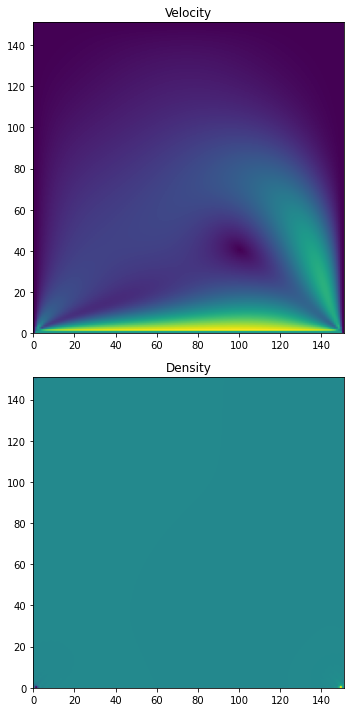

Commencing time step 30000
Commencing time step 35000
Commencing time step 40000
Commencing time step 45000
Lattice point updates per second = 3.33946e+06.


In [13]:
# commence time stepping
t0 = time.time()
for t in range(Num_ts):
    if t%5000 == 0:
        print(f'Commencing time step %i' % t);
           
    # compute density
    rho = np.sum(fIn,axis=0)
        
    # compute velocity
    ux = np.dot(np.transpose(ex),fIn)/rho
    uy = np.dot(np.transpose(ey),fIn)/rho
        
    # set microscopic Dirichlet-type BC
    ux_t = ux[vnl]; uy_t = uy[vnl];
    dx = u - ux_t; dy = 0. - uy_t;
    for spd in range(1,numSpd):
        cu = 3.*(ex[spd]*dx + ey[spd]*dy)
        fIn[spd][vnl]+=w[spd]*(rho[vnl]*cu)
               
    # set macroscopic Dirichlet-type boundary conditions
    ux[snl]=0.; uy[snl]=0.
    ux[vnl]=u; uy[vnl]=0.
        
    # compute Equilibrium density distribution
    fEq = np.zeros_like(fIn)
        
    for spd in range(numSpd):
        cu = 3.*(ex[spd]*ux + ey[spd]*uy)
        fEq[spd][:]=w[spd]*rho*(1.+cu + (0.5)*cu*cu -
                                (3./2.)*(ux*ux + uy*uy))
            
    # collide
    fOut = fIn - (fIn - fEq)*omega
        
    # bounce-back the solid nodes 
    for spd in range(numSpd):
        fOut[spd][snl]=fIn[bb_spd[spd]][snl]
            
    # stream
    for spd in range(numSpd):
        fIn[spd][stm[spd][:]]=fOut[spd][:]
        
        
    # write fIn data out after time step
    #np.save('step1_gold',fIn)
            
    if t%Vis_ts==0 and t>0:
        # do some visualization of the output
        uMag = np.sqrt(ux*ux + uy*uy)
        fig,(ax1,ax2) = plt.subplots(nrows=2,figsize=(6,10))
        ax1.imshow(np.reshape(uMag,(Ny,Nx)),extent=[0,Nx,0,Ny])
        ax1.set_title('Velocity')
        pressure = rho*p_conv_fact
        pressure -= pressure[int(nnodes/2)] # make pressure relative
        ax2.imshow(np.reshape(pressure,(Ny,Nx)),extent=[0,Nx,0,Ny])
        ax2.set_title('Density')
        plt.tight_layout()
        plt.show()
            
        
t1 = time.time();
elapsedTime = t1 - t0;
LPU = float(nnodes)*float(Num_ts)
LPU_sec = LPU/float(elapsedTime)
print(f'Lattice point updates per second = %g.' % LPU_sec)